Задание 1.
Реализуйте глубокую нейронную сеть (полносвязную или сверточную) и обучите ее на синтетических данных (например, наборы MNIST (http://yann.lecun.com/exdb/mnist/) или notMNIST).
Ознакомьтесь с имеющимися работами по данной тематике: англоязычная статья (http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf), видео на YouTube (https://www.youtube.com/watch?v=vGPI_JvLoN0).
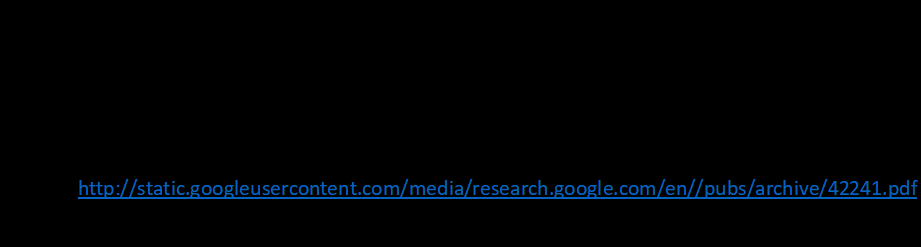

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Определяем устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используем устройство:", device)

# Трансформации
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Датасеты
train_ds = datasets.MNIST(root="./notMNIST_clean_small", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./notMNIST_clean", train=False, download=True, transform=transform)

# DataLoader с условным pin_memory
train_loader = DataLoader(
    train_ds,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=(device.type == "cuda")  # включаем только если есть GPU
)

test_loader = DataLoader(
    test_ds,
    batch_size=256,
    shuffle=False,
    num_workers=2,
    pin_memory=(device.type == "cuda")
)

# Пример цикла обучения
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.fc1   = nn.Linear(64 * 14 * 14, 128)
        self.fc2   = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Инициализация модели
model = SimpleCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# Обучение
for epoch in range(1, 6):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
    print(f"Эпоха {epoch} | Loss: {total_loss/total:.4f} | Acc: {correct/total:.4f}")

# Тестирование
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
print(f"Точность на тесте: {correct/total:.4f}")


Используем устройство: cpu
Эпоха 1 | Loss: 0.1352 | Acc: 0.9585
Эпоха 2 | Loss: 0.0371 | Acc: 0.9886
Эпоха 3 | Loss: 0.0224 | Acc: 0.9929
Эпоха 4 | Loss: 0.0151 | Acc: 0.9950
Эпоха 5 | Loss: 0.0103 | Acc: 0.9967
Точность на тесте: 0.9883
